In [ ]:
!pip install openai -q

In [65]:
!pip install pycocoevalcap
!pip install bert_score


In [64]:
!pip install streamlit
!pip install evaluate
!pip install rouge_score


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

file_path = "/content/cleaned_diet_rephrased_only (1).csv"
df = pd.read_csv(file_path)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.to_csv("diet_train.csv", index=False)
val_df.to_csv("diet_validation.csv", index=False)



In [ ]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import random

# Paths
train_jsonl_path = "/content/diet_train.jsonl"
val_jsonl_path = "/content/diet_validation.jsonl"

# Function to randomly rephrase the answer
def vary_completion_style(text):
    styles = [
        lambda x: x,
        lambda x: x.replace("•", "-").replace("*", "-"),
        lambda x: x.replace("Diet:", "Nutrition Plan:").replace("Calories:", "Energy Intake:"),
        lambda x: "Here is your tailored health plan:\n" + x,
    ]
    return random.choice(styles)(text)

# Generate fewer prompts with different phrasings
def create_multiple_prompts(row):
    gender = "male" if row['Gender'] == "male" else "female"
    base_info = (
        f"A {gender}, {row['Age']} years old, {row['Height_cm']} cm, "
        f"weighs {row['Weight_kg']} kg, BMI: {row['BMI']}, "
        f"suffers from {row['Disease_Type']} (Severity: {row['Severity']}), "
        f"activity level: {row['Physical_Activity_Level']}, "
        f"dietary restrictions: {row['Dietary_Restrictions']}, "
        f"allergies: {row['Allergies']}, prefers {row['Preferred_Cuisine']} food."
    )

    prompts = [
        f"Generate a full meal and fitness strategy for this profile: {base_info}",
        f"I'm seeking a health plan based on these details: {base_info}",
        f"Design a weekly nutrition and physical activity guide for: {base_info}"
    ]

    examples = []
    for prompt in prompts:
        examples.append({
            "messages": [
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": vary_completion_style(row["Personalized_Diet_Plan"])}
            ]
        })
    return examples

# Save training data
with open(train_jsonl_path, 'w', encoding='utf-8') as f:
    for _, row in train_df.iterrows():
        for example in create_multiple_prompts(row):
            json.dump(example, f, ensure_ascii=False)
            f.write('\n')

with open(val_jsonl_path, 'w', encoding='utf-8') as f:
    for _, row in val_df.iterrows():
        json.dump(create_multiple_prompts(row)[0], f, ensure_ascii=False)
        f.write('\n')

print("✅ JSONL updated with 3 varied prompts and rephrased completions!")


✅ JSONL updated with 3 varied prompts and rephrased completions!


In [ ]:
import os
from openai import OpenAI
from time import sleep

# Initialize OpenAI client
client = OpenAI(api_key = "add your api key here")

In [20]:
def upload_training_file(file_path):
    """Upload training file to OpenAI"""
    with open(file_path, "rb") as file:
        response = client.files.create(
            file=file,
            purpose="fine-tune"
        )
        return response.id


In [22]:
training_file_id = upload_training_file("/content/diet_train (1).jsonl")
validation_file_id = upload_training_file("/content/diet_validation (3).jsonl")
training_file_id,validation_file_id


('file-UYie7XrhJUxUcUgDqNdxC3', 'file-RPd6EmMEaoGJ6WxE3uk2aZ')

In [23]:
def create_fine_tuning_job(training_file_id, validation_file_id=None, model="gpt-4o-mini-2024-07-18"):
    """Create a fine-tuning job"""
    response = client.fine_tuning.jobs.create(
        training_file=training_file_id,
        validation_file=validation_file_id,
        model=model,
        hyperparameters={
            "n_epochs": 3,
            "batch_size": 2,

        }
    )
    return response.id


In [24]:
model="gpt-4o-mini-2024-07-18"
job_id = create_fine_tuning_job(training_file_id, validation_file_id, model)
job_id


'ftjob-TJZuhf4FyFtV8h6q37HXZRYz'

In [ ]:
def monitor_job(job_id):
    """Monitor fine-tuning job progress"""
    while True:
        job = client.fine_tuning.jobs.retrieve(job_id)
        print(f"Status: {job.status}")

        if job.status in ["succeeded", "failed"]:
            return job

        # List latest events
        events = client.fine_tuning.jobs.list_events(
            fine_tuning_job_id=job_id,
            limit=5
        )
        for event in events.data:
            print(f"Event: {event.message}")

        sleep(30)  # Check every 30 seconds

In [ ]:
job =  monitor_job(job_id)
if job.status == "succeeded":
  fine_tuned_model = job.fine_tuned_model
  print(f"Fine-tuned model ID: {fine_tuned_model}")
else:
  print("Fine-tuning failed.")

Status: validating_files
Event: Validating training file: file-XTALKtwmk2oLN1osbCjjwb and validation file: file-7R5Y2dsuncCRYa5fDYM31P
Event: Created fine-tuning job: ftjob-jWRsJp3QMWl70SJ0M62sVThI
Status: validating_files
Event: Validating training file: file-XTALKtwmk2oLN1osbCjjwb and validation file: file-7R5Y2dsuncCRYa5fDYM31P
Event: Created fine-tuning job: ftjob-jWRsJp3QMWl70SJ0M62sVThI
Status: validating_files
Event: Validating training file: file-XTALKtwmk2oLN1osbCjjwb and validation file: file-7R5Y2dsuncCRYa5fDYM31P
Event: Created fine-tuning job: ftjob-jWRsJp3QMWl70SJ0M62sVThI
Status: validating_files
Event: Validating training file: file-XTALKtwmk2oLN1osbCjjwb and validation file: file-7R5Y2dsuncCRYa5fDYM31P
Event: Created fine-tuning job: ftjob-jWRsJp3QMWl70SJ0M62sVThI
Status: validating_files
Event: Validating training file: file-XTALKtwmk2oLN1osbCjjwb and validation file: file-7R5Y2dsuncCRYa5fDYM31P
Event: Created fine-tuning job: ftjob-jWRsJp3QMWl70SJ0M62sVThI
Status: va

In [39]:
import openai
def test_model(model_id, test_input):
    """Test the fine-tuned model"""
    completion = client.chat.completions.create(
        model=model_id,
        messages=[
            {
                "role": "system",
                "content": ""
            },
            {"role": "user", "content": test_input}
        ]
    )
    return completion.choices[0].message

In [46]:
fine_tuned_model='ft:gpt-4o-mini-2024-07-18:meead-sultan::BN4X6bXE'

In [47]:
custom_test_input = "Create a diet plan for a 25-year-old female with high cholesterol, preferring Mediterranean cuisine."
result = test_model(fine_tuned_model, custom_test_input)

In [48]:
result.content


'This is a customized plan based on your profile:\nlow saturated fat and high fiber meals. Caloric intake: about 2000-2200 kcal per day.\n\nMeal Suggestions:\n- Breakfast: Greek yogurt with berries and oats\n- Lunch: Turkey panini with mozzarella and whole grain bread\n- Dinner: Baked salmon with roasted vegetables and pasta\n- Snacks: Mixed nuts or fruit\n\nLifestyle Tips:\n- Exercise: 30-60 minutes of moderate activity like swimming or cycling.\n- Sleep: Aim for 7-9 hours per night.'

In [ ]:
%%writefile gpt444.py
import streamlit as st
import openai
import os

import openai

openai.api_key = "add your api key here"


# Fine-Tuned Model ID
fine_tuned_model = "ft:gpt-4o-mini-2024-07-18:meead-sultan::BN4X6bXE"

# Initialize Streamlit UI
st.title("🍏 AI Diet Plan Generator")
st.write("Enter patient details to generate a personalized diet plan.")

# User Input
user_input = st.text_input("💬 Enter patient details (e.g., Create a diet plan for a 30-year-old male with diabetes)")

# Function to Generate Diet Plan Using Streaming
def generate_diet_plan(user_prompt):
    try:
        response = openai.ChatCompletion.create(
            model=fine_tuned_model,
            messages=[
                {"role": "system", "content": "You are a professional dietitian and fitness coach."},
                {"role": "user", "content": user_prompt}
            ],
            stream=True  # Enable Streaming
        )

        # Return streamed text output
        for chunk in response:
            if "choices" in chunk and chunk["choices"]:
                yield chunk["choices"][0]["delta"].get("content", "")

    except openai.error.AuthenticationError:
        yield "❌ **Authentication Error: Invalid API Key.** Please check your API key and try again."

# Generate Button
if st.button("🔍 Generate Diet Plan"):
    if user_input:
        st.write("⏳ **Generating diet plan...**")

        # Display streamed text
        diet_plan_text = st.empty()
        full_text = ""

        for text_chunk in generate_diet_plan(user_input):
            full_text += text_chunk
            diet_plan_text.markdown(full_text)  # Update text in Streamlit

        st.success("✅ Diet plan generated successfully!")
    else:
        st.warning("⚠️ Please enter patient details!")


Writing gpt444.py


In [ ]:
import json
from openai import OpenAI
import time

validation_path = "/content/diet_validation (3).jsonl"
prompts = []
references = []

with open(validation_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        user_msg = None
        assistant_msg = None
        for msg in data["messages"]:
            if msg["role"] == "user":
                user_msg = msg["content"]
            elif msg["role"] == "assistant":
                assistant_msg = msg["content"]
        if user_msg and assistant_msg:
            prompts.append(user_msg)
            references.append(assistant_msg)

client = OpenAI(api_key="add your api key here")

predictions = []

for i, prompt in enumerate(prompts):
    response = client.chat.completions.create(
        model="ft:gpt-4o-mini-2024-07-18:meead-sultan::BN4X6bXE",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    answer = response.choices[0].message.content.strip()
    predictions.append(answer)
    print(f"[{i+1}/{len(prompts)}] ✅")

    time.sleep(0.5)




[1/200] ✅
[2/200] ✅
[3/200] ✅
[4/200] ✅
[5/200] ✅
[6/200] ✅
[7/200] ✅
[8/200] ✅
[9/200] ✅
[10/200] ✅
[11/200] ✅
[12/200] ✅
[13/200] ✅
[14/200] ✅
[15/200] ✅
[16/200] ✅
[17/200] ✅
[18/200] ✅
[19/200] ✅
[20/200] ✅
[21/200] ✅
[22/200] ✅
[23/200] ✅
[24/200] ✅
[25/200] ✅
[26/200] ✅
[27/200] ✅
[28/200] ✅
[29/200] ✅
[30/200] ✅
[31/200] ✅
[32/200] ✅
[33/200] ✅
[34/200] ✅
[35/200] ✅
[36/200] ✅
[37/200] ✅
[38/200] ✅
[39/200] ✅
[40/200] ✅
[41/200] ✅
[42/200] ✅
[43/200] ✅
[44/200] ✅
[45/200] ✅
[46/200] ✅
[47/200] ✅
[48/200] ✅
[49/200] ✅
[50/200] ✅
[51/200] ✅
[52/200] ✅
[53/200] ✅
[54/200] ✅
[55/200] ✅
[56/200] ✅
[57/200] ✅
[58/200] ✅
[59/200] ✅
[60/200] ✅
[61/200] ✅
[62/200] ✅
[63/200] ✅
[64/200] ✅
[65/200] ✅
[66/200] ✅
[67/200] ✅
[68/200] ✅
[69/200] ✅
[70/200] ✅
[71/200] ✅
[72/200] ✅
[73/200] ✅
[74/200] ✅
[75/200] ✅
[76/200] ✅
[77/200] ✅
[78/200] ✅
[79/200] ✅
[80/200] ✅
[81/200] ✅
[82/200] ✅
[83/200] ✅
[84/200] ✅
[85/200] ✅
[86/200] ✅
[87/200] ✅
[88/200] ✅
[89/200] ✅
[90/200] ✅
[91/200] ✅
[92/200]

In [4]:
print(len(predictions))
print(len(prompts))
print(len(references))

200
200
200


In [6]:
import evaluate

bleu = evaluate.load("bleu")
bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
print("\n BLEU Score:", bleu_score["bleu"])

rouge = evaluate.load("rouge")
rouge_score = rouge.compute(predictions=predictions, references=references)

print("\n ROUGE Scores:")
print("ROUGE-1:", rouge_score["rouge1"])
print("ROUGE-2:", rouge_score["rouge2"])
print("ROUGE-L:", rouge_score["rougeL"])
print("ROUGE-Lsum:", rouge_score["rougeLsum"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



 BLEU Score: 0.9676195888733798



 ROUGE Scores:
ROUGE-1: 0.9818543962108279
ROUGE-2: 0.9816399567486317
ROUGE-L: 0.9818959422705995
ROUGE-Lsum: 0.9819660311237137


In [8]:
import evaluate

bertscore = evaluate.load("bertscore")
score = bertscore.compute(predictions=predictions, references=references, lang="en")
print("BERTScore - Precision:", sum(score["precision"]) / len(score["precision"]))
print("BERTScore - Recall:", sum(score["recall"]) / len(score["recall"]))
print("BERTScore - F1:", sum(score["f1"]) / len(score["f1"]))


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore - Precision: 0.9968958893418312
BERTScore - Recall: 0.9924333265423775
BERTScore - F1: 0.9946504005789757


In [ ]:
import json
import evaluate
from openai import OpenAI

test_path = "/content/diet_test_10_groud.jsonl"
promptsTest = []
referencesTest = []

with open(test_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        messages = data["messages"]
        for msg in messages:
            if msg["role"] == "user":
                promptsTest.append(msg["content"])
            elif msg["role"] == "assistant":
                referencesTest.append(msg["content"])

client = OpenAI(api_key="=add your api key here")

predictionsTest = []

for prompt in promptsTest:
    response = client.chat.completions.create(
        model="ft:gpt-4o-mini-2024-07-18:meead-sultan::BN4X6bXE",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    answer = response.choices[0].message.content.strip()
    predictionsTest.append(answer)




In [11]:
print(len(predictionsTest))
print(len(promptsTest))

10
10


In [51]:
bertscore = evaluate.load("bertscore")
score = bertscore.compute(predictions=predictionsTest, references=referencesTest, lang="en")

print("BERTScore - Precision:", sum(score["precision"]) / len(score["precision"]))
print("BERTScore - Recall:", sum(score["recall"]) / len(score["recall"]))
print("BERTScore - F1:", sum(score["f1"]) / len(score["f1"]))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore - Precision: 0.9853793919086457
BERTScore - Recall: 0.9829039335250854
BERTScore - F1: 0.984127551317215


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


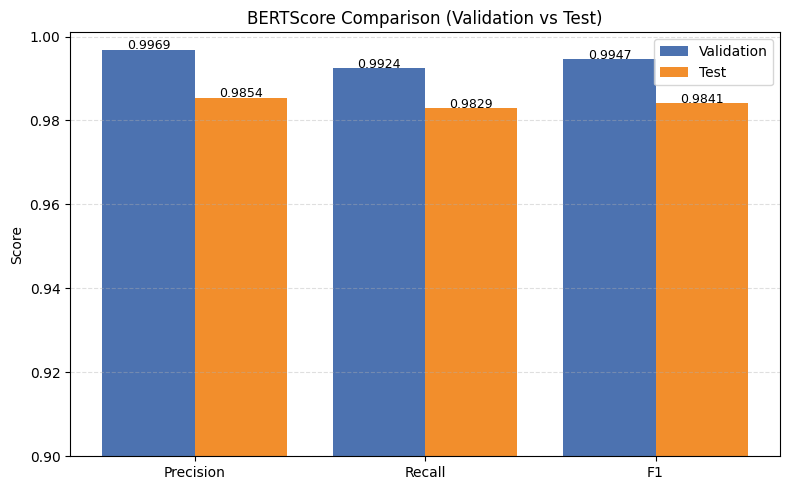

In [13]:
import evaluate
import matplotlib.pyplot as plt

bertscore = evaluate.load("bertscore")
val_score = bertscore.compute(predictions=predictions, references=references, lang="en")
val_precision = sum(val_score["precision"]) / len(val_score["precision"])
val_recall = sum(val_score["recall"]) / len(val_score["recall"])
val_f1 = sum(val_score["f1"]) / len(val_score["f1"])

test_score = bertscore.compute(predictions=predictionsTest, references=referencesTest, lang="en")
test_precision = sum(test_score["precision"]) / len(test_score["precision"])
test_recall = sum(test_score["recall"]) / len(test_score["recall"])
test_f1 = sum(test_score["f1"]) / len(test_score["f1"])

labels = ["Precision", "Recall", "F1"]
val_values = [val_precision, val_recall, val_f1]
test_values = [test_precision, test_recall, test_f1]

x = range(len(labels))
bar_width = 0.4

plt.figure(figsize=(8, 5))
bars1 = plt.bar([i - 0.2 for i in x], val_values, width=bar_width, label="Validation", color="#4c72b0")
bars2 = plt.bar([i + 0.2 for i in x], test_values, width=bar_width, label="Test", color="#f28e2c")

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.0001, f"{height:.4f}", ha="center", fontsize=9)

plt.xticks(x, labels)
plt.title("BERTScore Comparison (Validation vs Test)")
plt.ylabel("Score")
plt.ylim(0.90, 1.001)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [61]:

from pycocoevalcap.meteor.meteor import Meteor
import evaluate

meteor = evaluate.load("meteor")

meteor_score = meteor.compute(predictions=predictions, references=references)

print("\nMETEOR Score:", meteor_score["meteor"])



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



METEOR Score: 0.9710747679478733
